# Random Forest Model

## Load the Libraries

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Find the latest version of Spark 3.x from https://downloads.apache.org/spark/ and enter as the spark version
spark_version = 'spark-3.5.2'
os.environ['SPARK_VERSION'] = spark_version
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark
# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"
# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [998 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,293 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,149 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,572 kB]
Hit:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease


In [10]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("breastCancerAnalysis").getOrCreate()

In [11]:
# Read in data from S3 Buckets or local file
from pyspark import SparkFiles
url = "Resources/breast_cancer_dataset.csv"
spark.sparkContext.addFile(url)
df = spark.read.option('header', 'true').csv(SparkFiles.get("breast_cancer_dataset.csv"), inferSchema=True, sep=',')
# Show DataFrame
df.show()

+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+--------+---------+-----------+------------+---

In [15]:
# Convert Spark DataFrame to Pandas DataFrame for compatibility with scikit-learn
df = df.toPandas()

## Split the Data

In [16]:
# Separate features (X) and target variable (y)
X = df.drop(['id', 'diagnosis'], axis=1)  # Exclude 'id' and 'diagnosis' columns from features
y = df['diagnosis']  # Target variable
len(df)

569

In [17]:
# # Map 'M' to 1 and 'B' to 0 in the 'diagnosis' column
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [18]:
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## Split Dataframe into Two Based on Diagnosis


In [19]:

# split dataframe into two based on diagnosis
dfM=df[df['diagnosis'] ==1]
dfB=df[df['diagnosis'] ==0]

In [20]:
dfM.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,2.120000e+02,212.0,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,...,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,3.681805e+07,1.0,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,...,21.134811,29.318208,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530
std,1.378965e+08,0.0,3.203971,3.779470,21.854653,367.937978,0.012608,0.053987,0.075019,0.034374,...,4.283569,5.434804,29.457055,597.967743,0.021870,0.170372,0.181507,0.046308,0.074685,0.021553
min,8.670000e+03,1.0,10.950000,10.380000,71.900000,361.600000,0.073710,0.046050,0.023980,0.020310,...,12.840000,16.670000,85.100000,508.100000,0.088220,0.051310,0.023980,0.028990,0.156500,0.055040
25%,8.613450e+05,1.0,15.075000,19.327500,98.745000,705.300000,0.094010,0.109600,0.109525,0.064620,...,17.730000,25.782500,119.325000,970.300000,0.130475,0.244475,0.326425,0.152750,0.276500,0.076302
50%,8.953665e+05,1.0,17.325000,21.460000,114.200000,932.000000,0.102200,0.132350,0.151350,0.086280,...,20.590000,28.945000,138.000000,1303.000000,0.143450,0.356350,0.404900,0.182000,0.310300,0.087600
75%,8.911290e+06,1.0,19.590000,23.765000,129.925000,1203.750000,0.110925,0.172400,0.203050,0.103175,...,23.807500,32.690000,159.800000,1712.750000,0.155975,0.447850,0.556175,0.210675,0.359225,0.102625
max,9.112962e+08,1.0,28.110000,39.280000,188.500000,2501.000000,0.144700,0.345400,0.426800,0.201200,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.170000,0.291000,0.663800,0.207500


In [21]:
dfB.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,3.570000e+02,357.0,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,...,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,2.654382e+07,0.0,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,...,13.379801,23.515070,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442
std,1.167397e+08,0.0,1.780512,3.995125,11.807438,134.287118,0.013446,0.033750,0.043442,0.015909,...,1.981368,5.493955,13.527091,163.601424,0.020013,0.092180,0.140368,0.035797,0.041745,0.013804
min,8.913000e+03,0.0,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156600,0.055210
25%,8.746620e+05,0.0,11.080000,15.150000,70.870000,378.200000,0.083060,0.055620,0.020310,0.015020,...,12.080000,19.580000,78.270000,447.100000,0.110400,0.112000,0.077080,0.051040,0.240600,0.070090
50%,9.089160e+05,0.0,12.200000,17.390000,78.180000,458.400000,0.090760,0.075290,0.037090,0.023440,...,13.350000,22.820000,86.920000,547.400000,0.125400,0.169800,0.141200,0.074310,0.268700,0.077120
75%,8.812816e+06,0.0,13.370000,19.760000,86.100000,551.100000,0.100700,0.097550,0.059990,0.032510,...,14.800000,26.510000,96.590000,670.000000,0.137600,0.230200,0.221600,0.097490,0.298300,0.085410
max,9.113205e+08,0.0,17.850000,33.810000,114.600000,992.100000,0.163400,0.223900,0.410800,0.085340,...,19.820000,41.780000,127.100000,1210.000000,0.200600,0.584900,1.252000,0.175000,0.422800,0.148600


## Split Data into Training and Testing Sets

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
# Make predictions
y_pred = rf_model.predict(X_test)

In [25]:
# Make predictions
y_pred = rf_model.predict(X_test)

In [26]:
# Display the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           B       0.96      0.99      0.97        71
           M       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



# Classification Report Analysis

The classification report provides a detailed evaluation of the random forest model's performance on each class. Here’s a breakdown of the performance metrics based on the provided classification report:

### Class B(Benign):
- **Precision**: 0.96
  - Indicates that 96% of the samples predicted as class B are actually class B. Precision measures the proportion of true positives among all predicted positives for class B.

- **Recall**: 0.99
  - Shows that the model correctly identifies 99% of the actual class B samples. Recall measures the proportion of true positives among all actual positives for class B.

- **F1-Score**: 0.97
  - The harmonic mean of precision and recall for class B. An F1-score of 0.96 indicates very good performance, balancing both precision and recall.

### Class M(Malignant):
- **Precision**: 0.98
  - Indicates that 98% of the samples predicted as class M are actually class M. The model is highly accurate in identifying class M when it makes a prediction.

- **Recall**: 0.93
  - Shows that the model correctly identifies 93% of the actual class M samples. While still strong, recall for class M is lower compared to class B.

- **F1-Score**: 0.95
  - Reflects a balance between precision and recall for class M. An F1-score of 0.95 is slightly lower than for class B but still indicates good overall performance.

### Overall Metrics:
- **Accuracy**: 0.95
  - The model correctly classifies 95% of all samples, indicating high overall performance.

- **Macro Average**:
  - **Precision**: 0.97
  - **Recall**: 0.96
  - **F1-Score**: 0.96
  - The macro average is the average of the precision, recall, and F1-scores for each class, treating all classes equally. It reflects balanced performance across both classes.

- **Weighted Average**:
  - **Precision**: 0.97
  - **Recall**: 0.96
  - **F1-Score**: 0.96
  - The weighted average accounts for the support (number of true instances) of each class, providing an overall performance metric weighted by class distribution.

### Summary:
- **Class B**: The model has high recall (0.99), meaning it identifies most class 0 samples correctly. Precision is also high (0.96), indicating few false positives.
  
- **Class M**: The model shows high precision (0.98) and good recall (0.93), correctly identifying most class M samples with a small number of false positives.

Overall, the random forest model demonstrates strong performance across both classes. It is particularly effective at predicting class B and performs very well with class M, though recall for class M is slightly lower and can continue to be improved.

## Review Difference in Accuracy by Altering Number of Estimators in the Model

Accuracy Score with 10 estimators: 0.9561
Accuracy Score with 50 estimators: 0.9649
Accuracy Score with 100 estimators: 0.9649
Accuracy Score with 200 estimators: 0.9649
Accuracy Score with 500 estimators: 0.9649


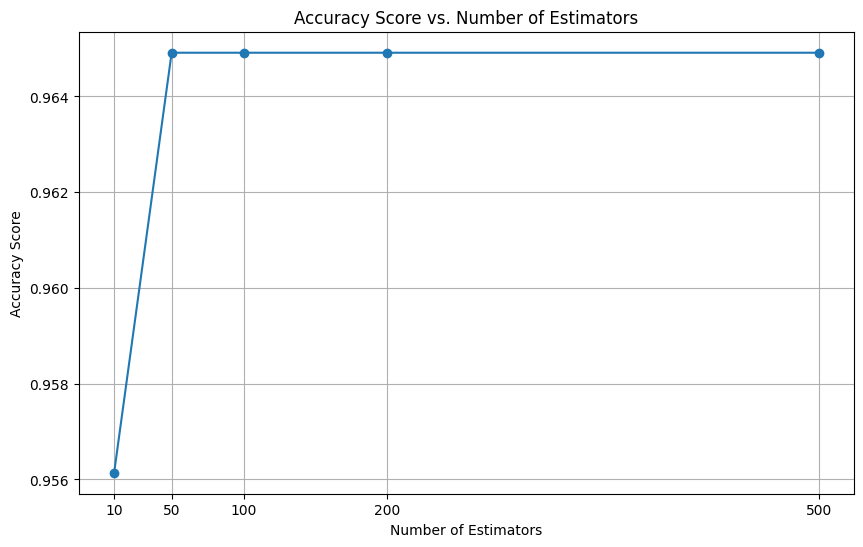

In [27]:
# Initialize a list to store accuracy scores
accuracy_scores = []
n_estimators_range = [10, 50, 100, 200, 500]  # You can adjust this range as needed

# Loop through the range of n_estimators
for n_estimators in n_estimators_range:
    # Create a Random Forest model with the current number of estimators
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_model.fit(X_train, y_train)  # Fit the model

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Calculate accuracy score
    acc_score = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc_score)

    # Print the accuracy score for the current number of estimators
    print(f'Accuracy Score with {n_estimators} estimators: {acc_score:.4f}')

# Plot the accuracy scores against the number of estimators
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracy_scores, marker='o')
plt.title('Accuracy Score vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.xticks(n_estimators_range)
plt.grid()
plt.show()

## Review Top Feature Importances to Use to Better Train Model

In [28]:
feature_importances = rf_model.feature_importances_

#alongside their labels
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
27,concave points_worst,0.139713
23,area_worst,0.122448
7,concave points_mean,0.115332
22,perimeter_worst,0.114410
20,radius_worst,0.082506
6,concavity_mean,0.051091
0,radius_mean,0.047065
2,perimeter_mean,0.041769
3,area_mean,0.040207
26,concavity_worst,0.038435


## Create Visualizations to Quickly View Relationships Between Feature Importances

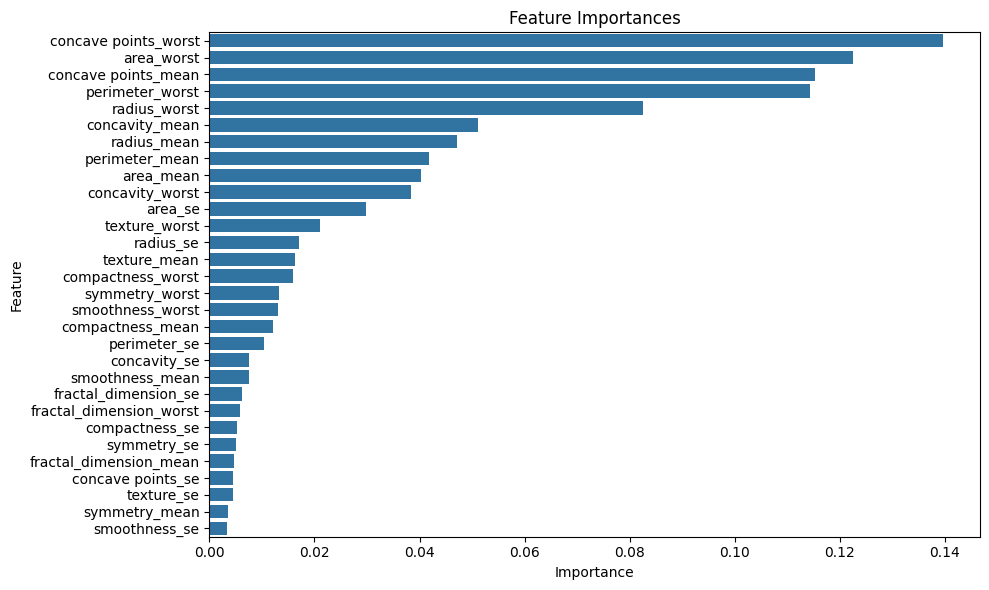

In [31]:
# Plotting all features to see importance
# Define the output directory
output_dir = 'Plots'

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

plt.show()

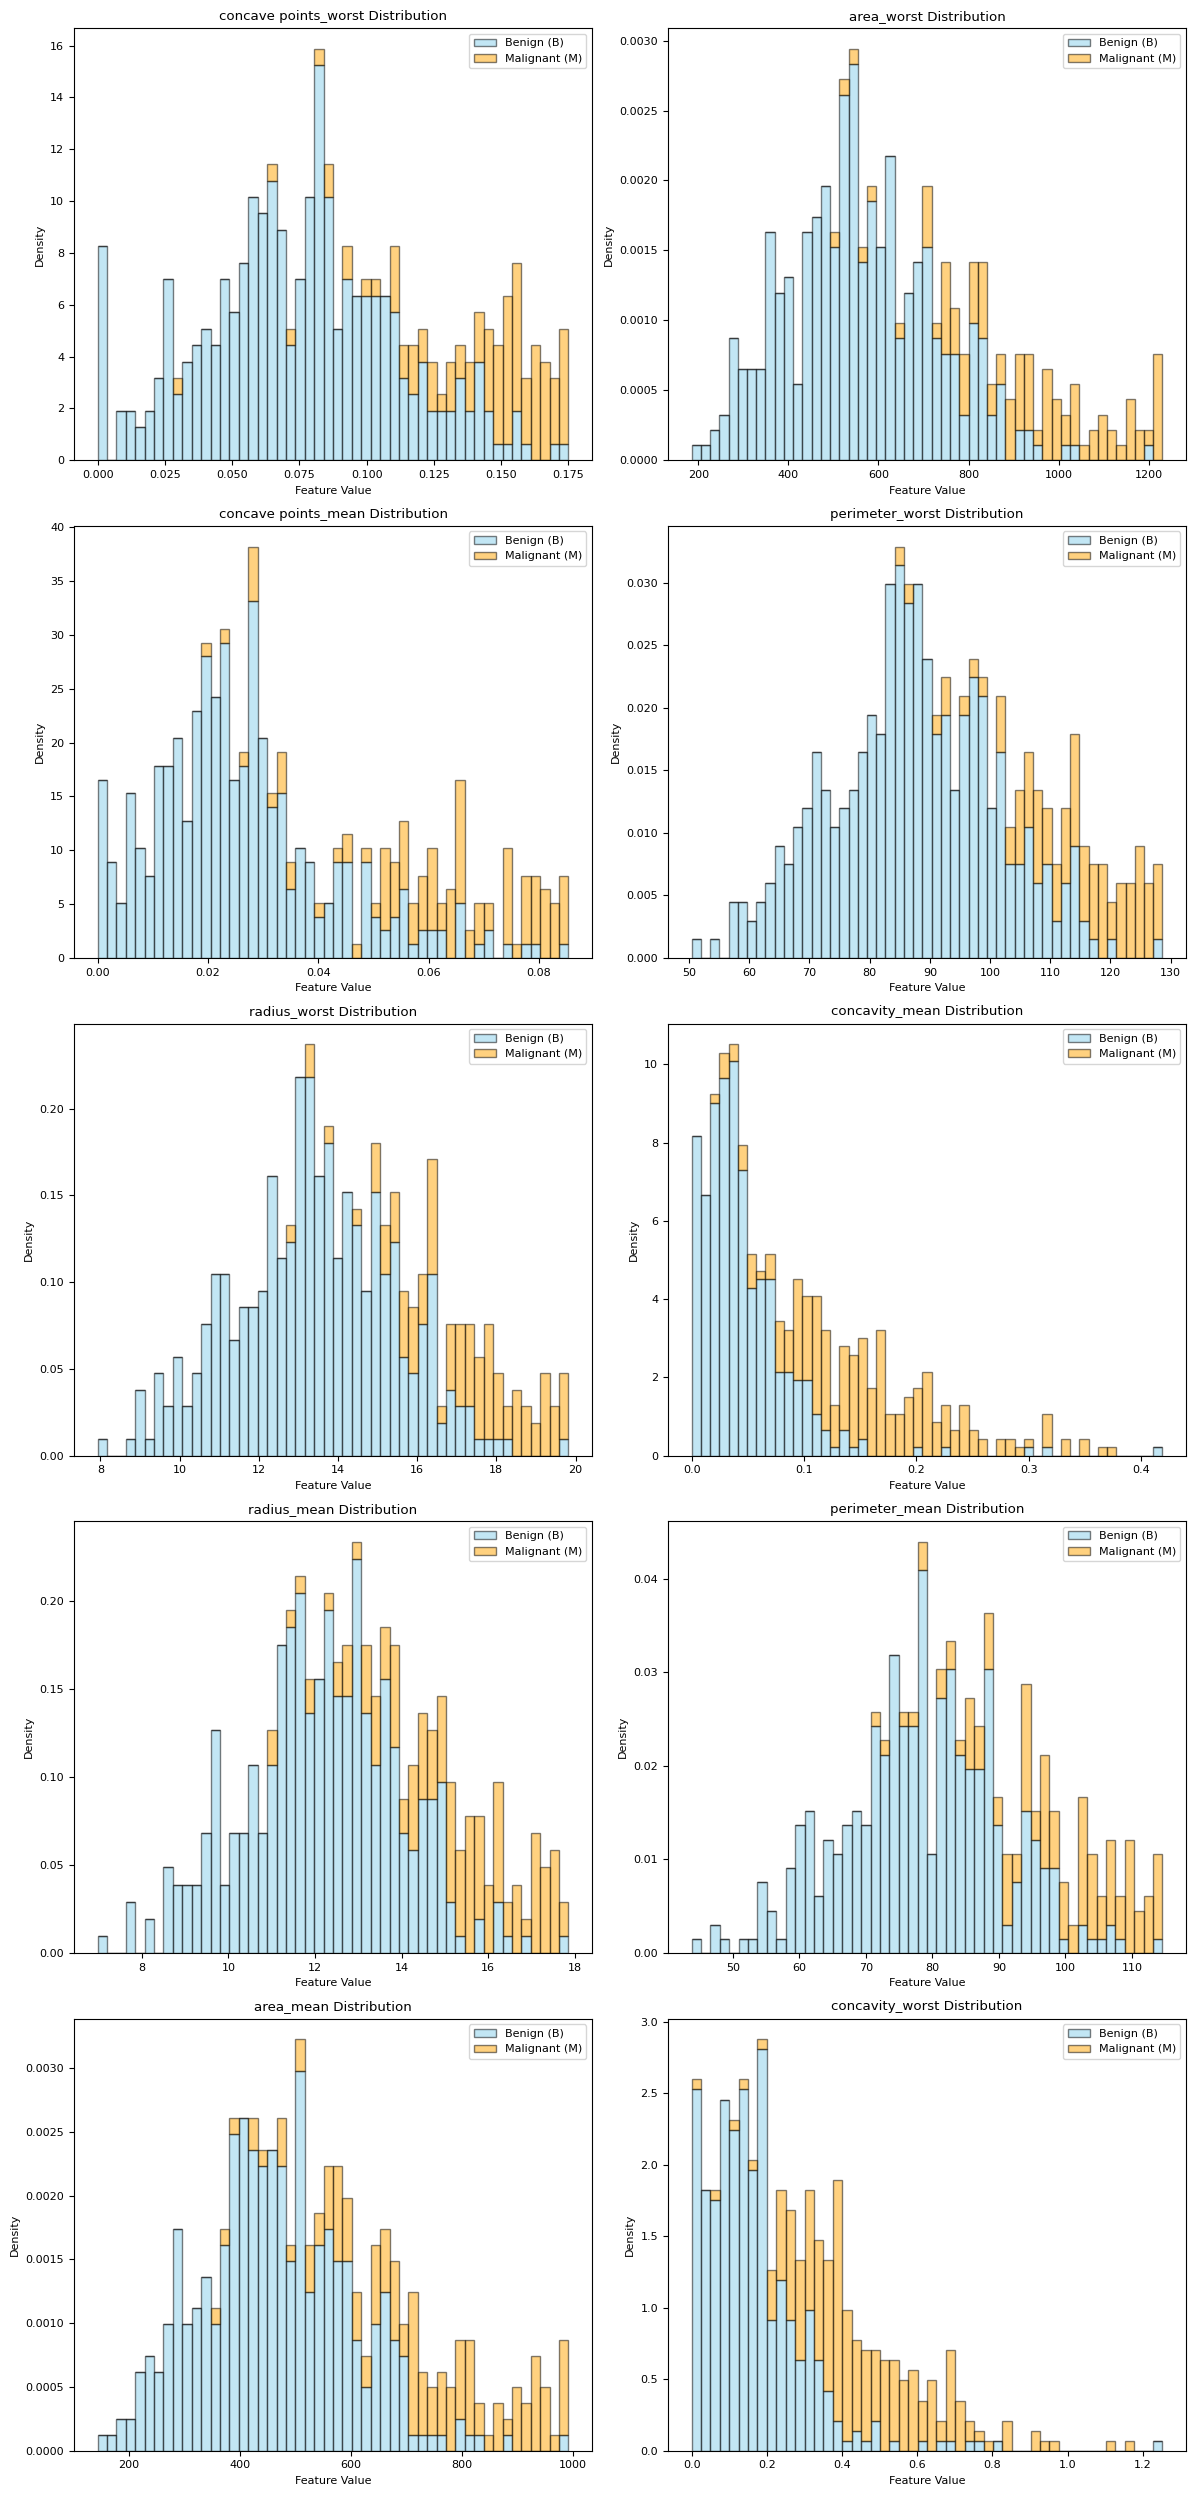

In [32]:
# Initially looking at top 10 features
# Extracting the top 10 features from the overall feature importances
top_10_features = importance_df.head(10)['Feature']

# Filtering the features in dfB and dfM based on the top 10 features
dfB_top10 = dfB[top_10_features]
dfM_top10 = dfM[top_10_features]

# Creating histograms for each feature
plt.rcParams.update({'font.size': 8})  # Updating font size for better readability
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 25))  # Adjusting subplot grid size for 10 features
axes = axes.ravel()

for idx, feature in enumerate(top_10_features):
    ax = axes[idx]  # Selecting subplot for current feature
    binwidth = (dfB[feature].max() - dfB[feature].min()) / 50  # Defining bin width

    # Plotting stacked histogram
    ax.hist([dfB[feature], dfM[feature]],
            bins=np.arange(dfB[feature].min(), dfB[feature].max() + binwidth, binwidth),
            alpha=0.5,
            stacked=True,
            density=True,
            label=['Benign (B)', 'Malignant (M)'],
            color=['skyblue', 'orange'],
            edgecolor='black')

    ax.legend(loc='upper right')
    ax.set_title(f'{feature} Distribution')
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Density')

#display
plt.tight_layout()
plt.show()

## Alter Code to Focus on "Mean" Feature Importances Only for Purposes of Accuracy

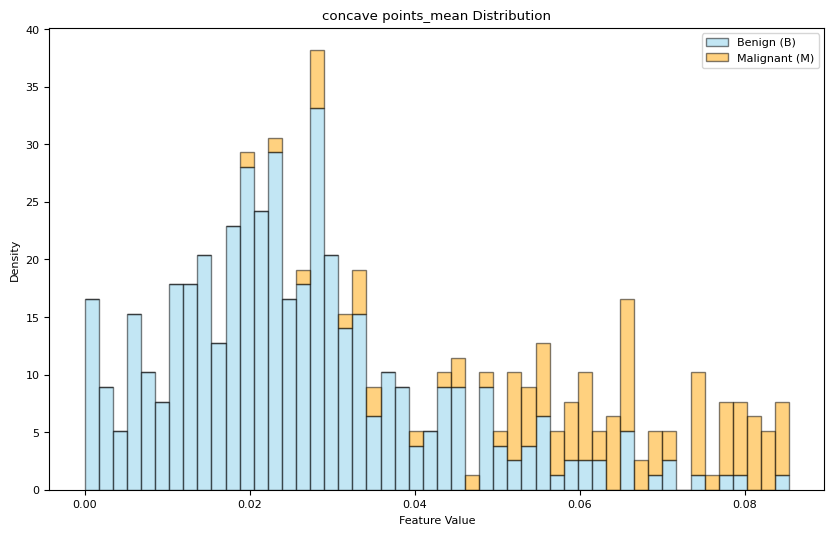

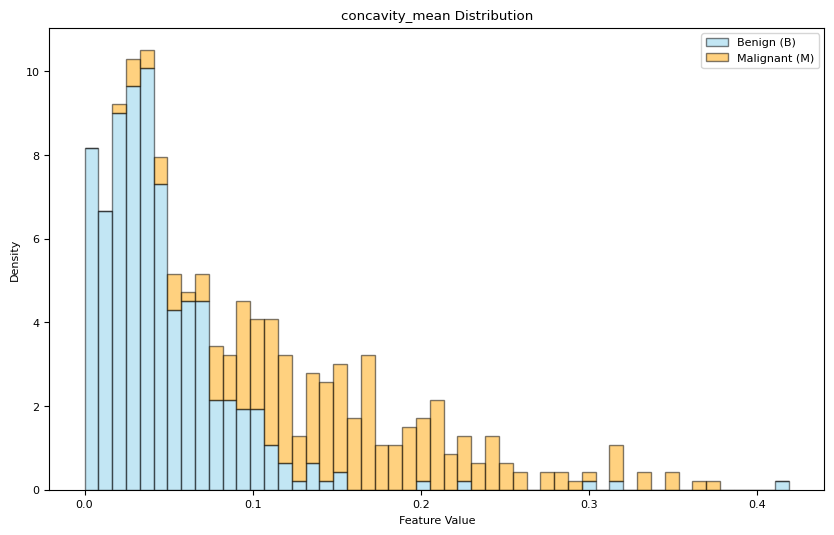

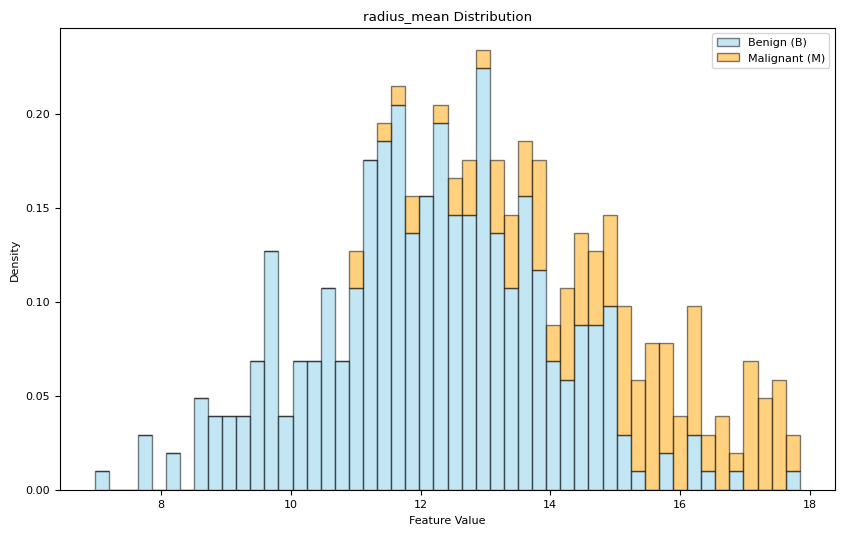

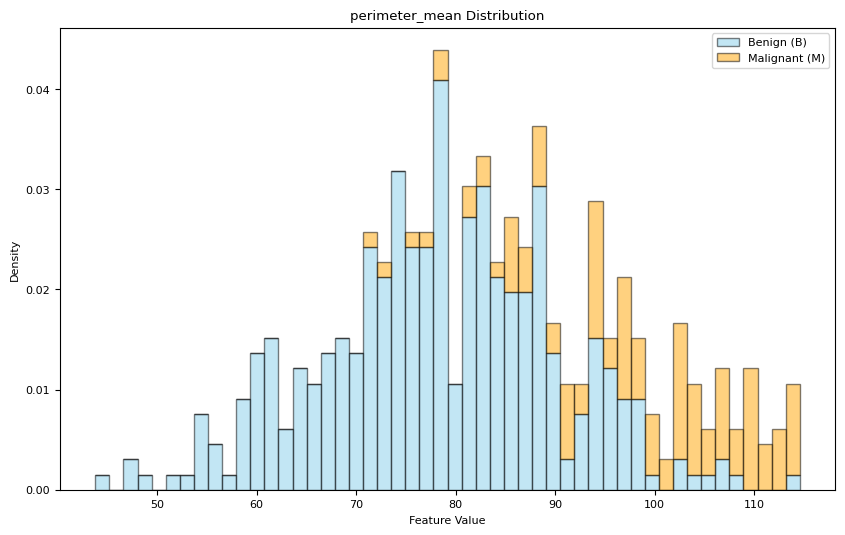

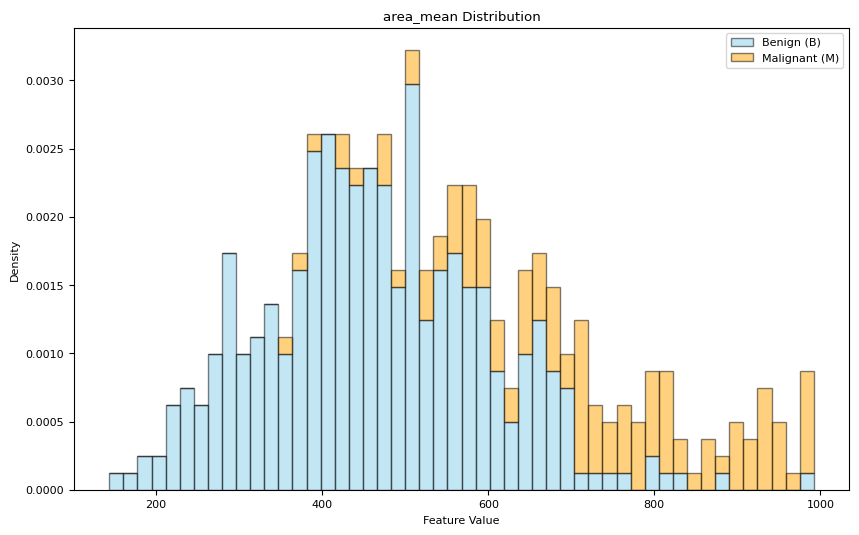

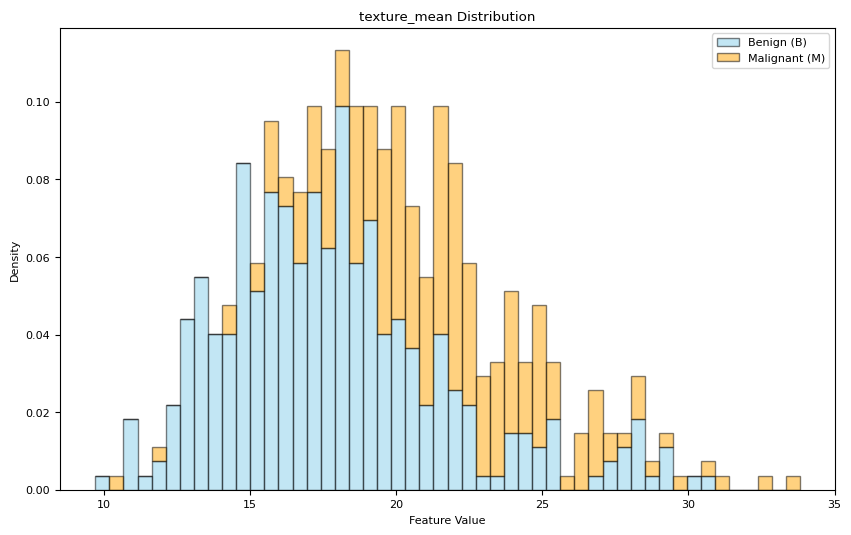

In [34]:
# Decided to focus specifically on top "mean" features
# Extracting the top 6 features that end with 'mean' from the overall feature importances
top_6_mean_features = importance_df[importance_df['Feature'].str.endswith('mean')].head(6)['Feature']

# Filtering the features in dfB and dfM based on the selected features
dfB_top6_mean = dfB[top_6_mean_features]
dfM_top6_mean = dfM[top_6_mean_features]

# Directory to save the plots
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

# Creating histograms for each of the selected features
for feature in top_6_mean_features:
    plt.figure(figsize=(10, 6))
    binwidth = (dfB[feature].max() - dfB[feature].min()) / 50

    # Plot stacked histogram
    plt.hist([dfB[feature], dfM[feature]],
             bins=np.arange(dfB[feature].min(), dfB[feature].max() + binwidth, binwidth),
             alpha=0.5,
             stacked=True,
             density=True,  # Normalizes the histogram to show probability densities
             label=['Benign (B)', 'Malignant (M)'],
             color=['skyblue', 'orange'],
             edgecolor='black')

    plt.legend(loc='upper right')
    plt.title(f'{feature} Distribution')
    plt.xlabel('Feature Value')
    plt.ylabel('Density')

    # Saving the plot as a PNG file
    plt.savefig(os.path.join(output_dir, f'{feature}_distribution.png'))

    # Display
    plt.show()

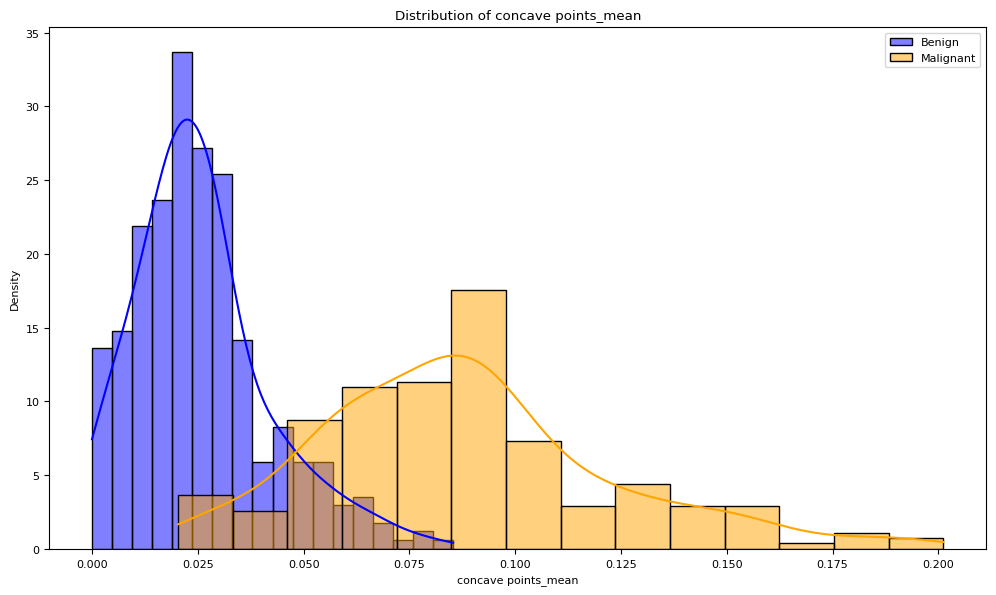

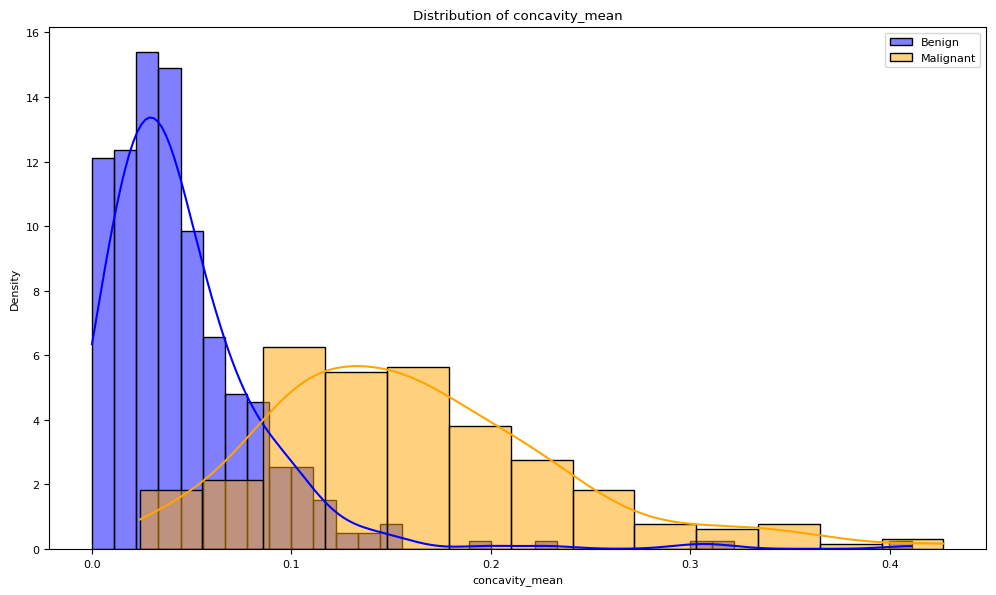

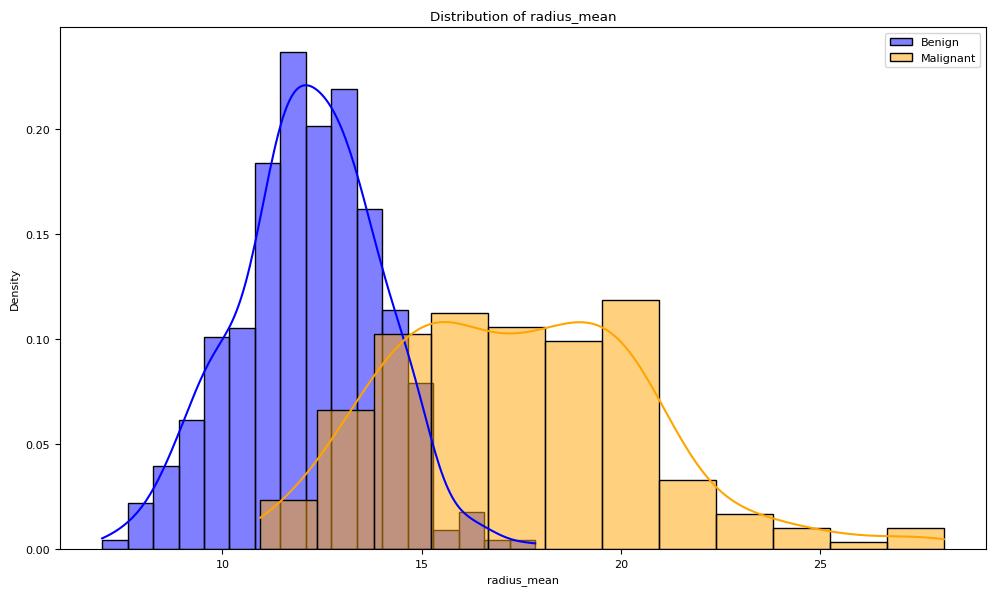

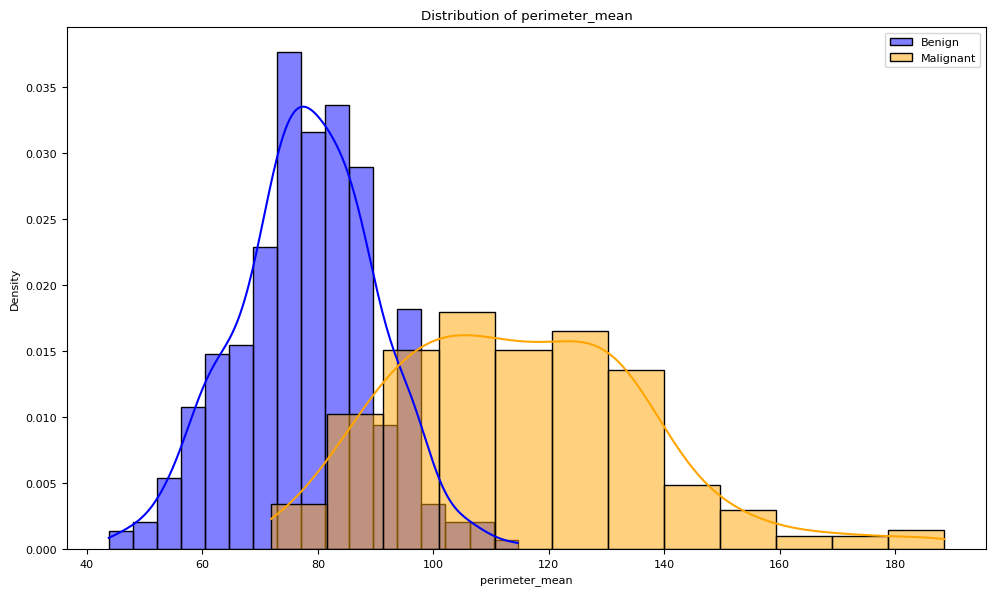

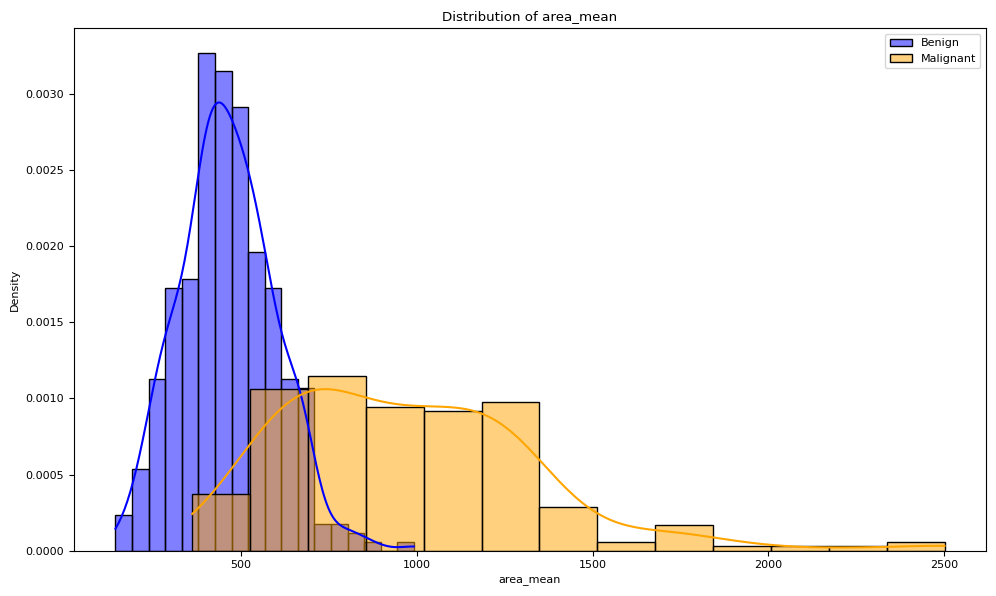

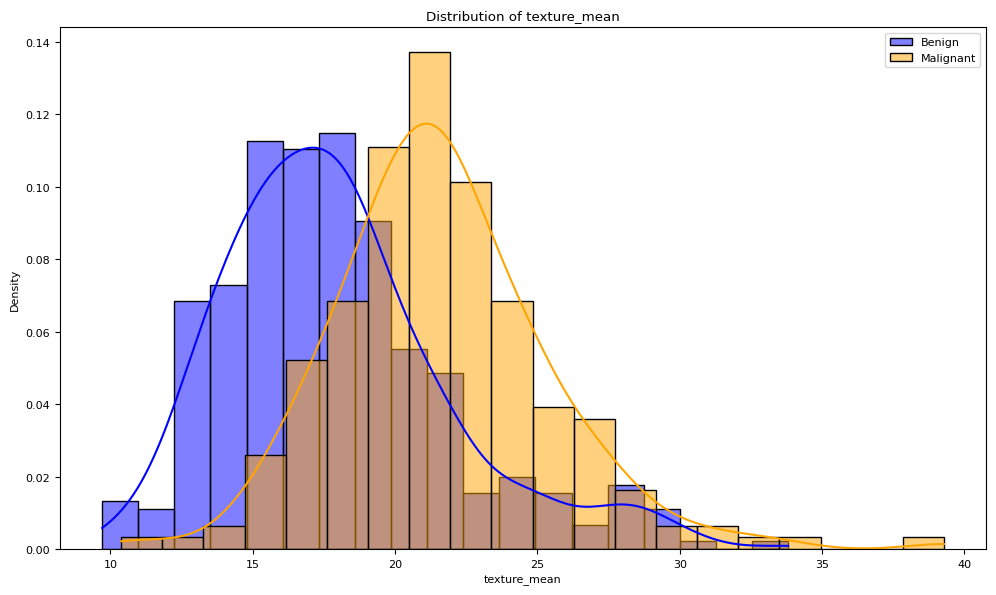

In [35]:
# Different graph for all 6 mean features
# Creating a directory to save the plots if it doesn't exist
output_dir = 'plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Extracting the top 6 features that end with 'mean' from the overall feature importances
top_6_mean_features = importance_df[importance_df['Feature'].str.endswith('mean')].head(6)['Feature']

# Plotting histograms for each of the selected features and save them as images
for feature in top_6_mean_features:
    plt.figure(figsize=(10, 6))

    # Plot histograms for benign (0) and malignant (1) cases
    sns.histplot(df[df['diagnosis'] == 0][feature], color='blue', label='Benign', kde=True, stat='density')
    sns.histplot(df[df['diagnosis'] == 1][feature], color='orange', label='Malignant', kde=True, stat='density')

    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()

    # Saving the plot as a PNG file
    plt.savefig(os.path.join(output_dir, f'{feature}_distribution2.png'))

    # Display
    plt.show()

## Upon Review, we can determine the Top 5 Features are: "compactness_mean", "area_mean", "radius_mean", "concavity_mean" and "perimeter_mean".
## We will alter the model to use the Top 5 Features as predictors to see if accuracy improves:

In [36]:
# Top 5 Features: 'radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean'
# Extracting the top 5 features that end with 'mean' from the overall feature importances
top_5_features = importance_df[importance_df['Feature'].str.endswith('mean')].head(5)['Feature']

# Filter the original features to only include the top 5 features
X_top5 = X[top_5_features]

# Split the data into training and testing sets using the top 5 features
X_train_top5, X_test_top5, y_train, y_test = train_test_split(X_top5, y, test_size=0.2, random_state=42)

# Create a Random Forest model
rf_model_top5 = RandomForestClassifier(random_state=42)
rf_model_top5.fit(X_train_top5, y_train)

# Make predictions
y_pred_top5 = rf_model_top5.predict(X_test_top5)

In [37]:
# Display the classification report for the model using top 5 features
print('Classification Report for Top 5 Features:')
print(classification_report(y_test, y_pred_top5))

Classification Report for Top 5 Features:
              precision    recall  f1-score   support

           B       0.95      0.97      0.96        71
           M       0.95      0.91      0.93        43

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



## We will now extract the Bottom 6 Features:

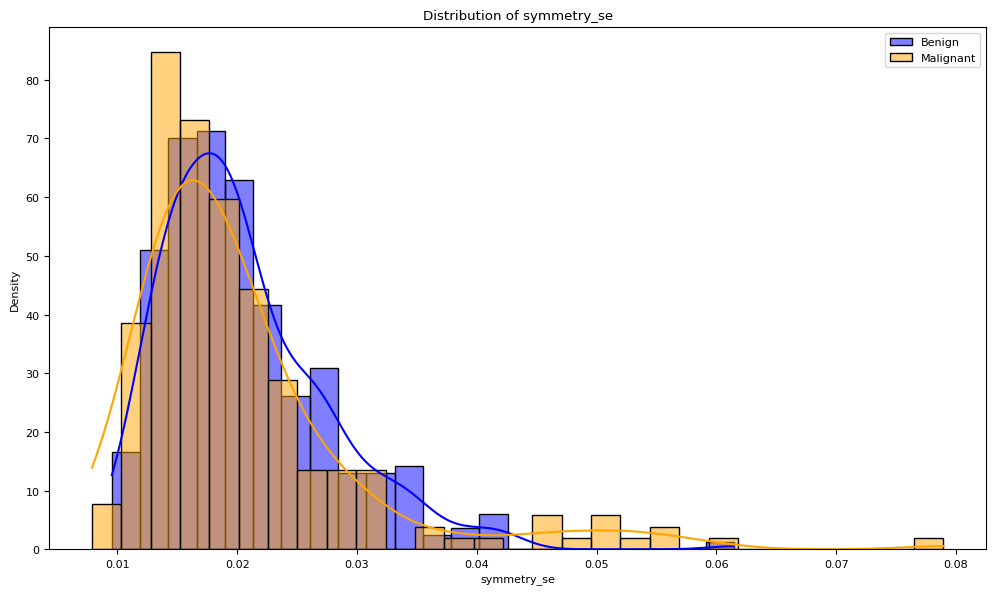

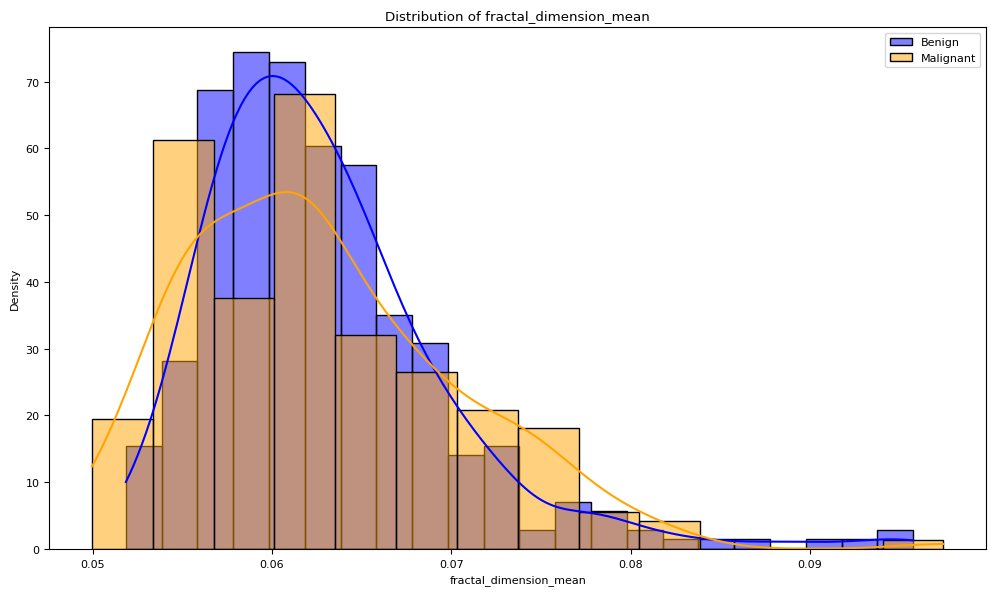

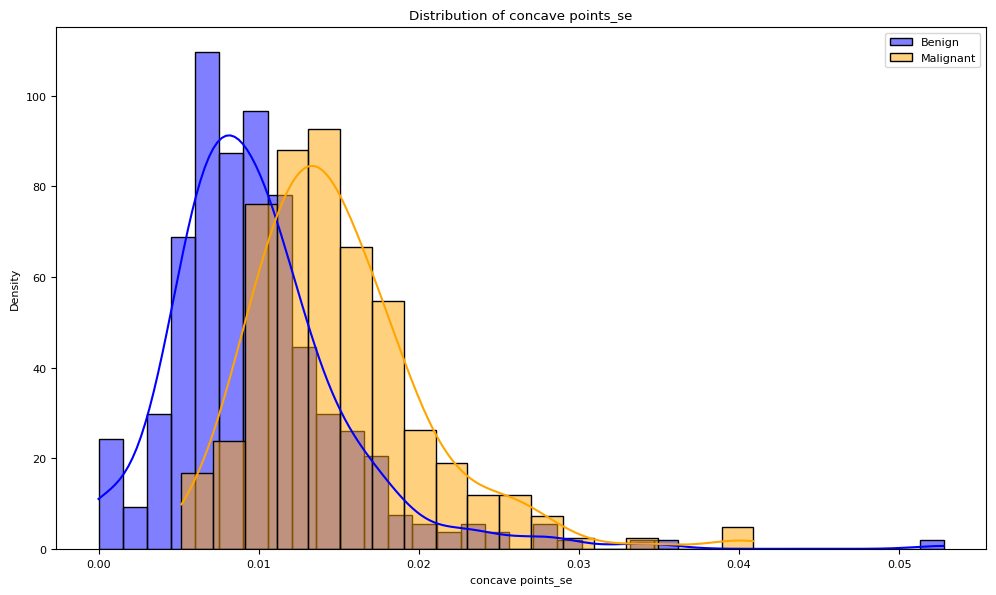

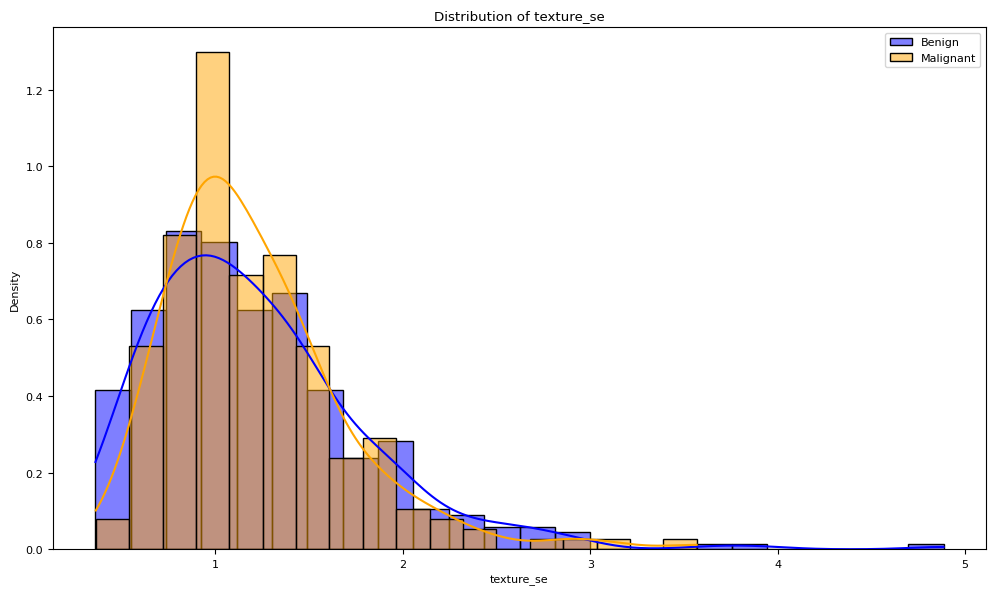

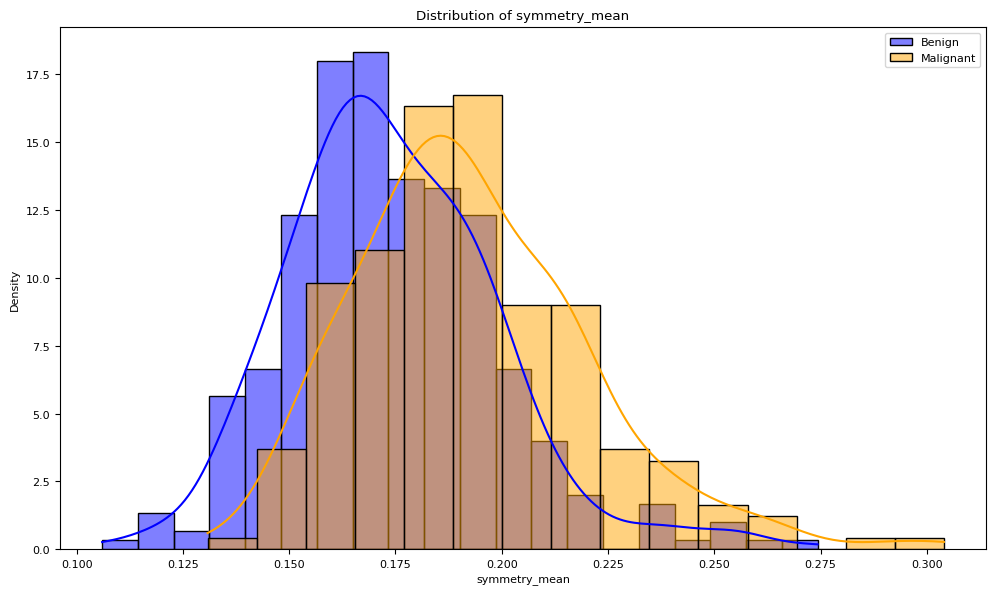

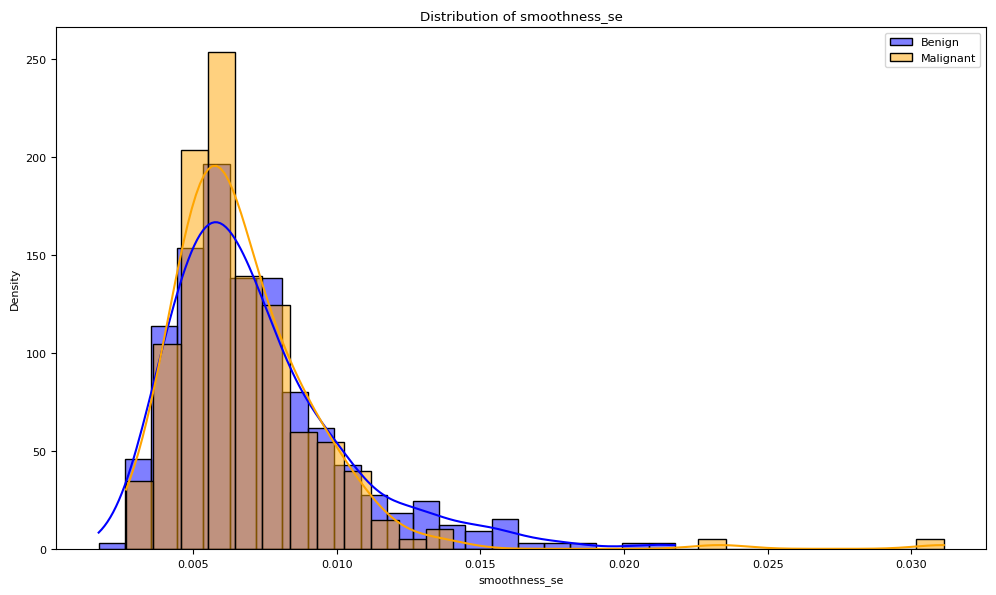

In [38]:
#Plotting bottom 6 features for comparison
# Extracting the bottom 6 features (based on importance) from the overall feature importances
bottom_6_features = importance_df.tail(6)['Feature']

# Plotting histograms for each of the selected features without saving as images
for feature in bottom_6_features:
    plt.figure(figsize=(10, 6))

    # Plot histograms for benign (0) and malignant (1) cases
    sns.histplot(df[df['diagnosis'] == 0][feature], color='blue', label='Benign', kde=True, stat='density')
    sns.histplot(df[df['diagnosis'] == 1][feature], color='orange', label='Malignant', kde=True, stat='density')

    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()

    # Display the plot in the notebook
    plt.show()

### From the visualizations, we can determine the Bottom 6 Feature Importances are: "concave points_se", "symmetry_mean", fractal_dimension_mean", "symmetry_se", "smoothnes_se" and "texture_se". Meaning these features have the least impact on defining a tumor to be malignant or benign.

## Let's adjust the model to remove the bottom 6 to see if it improves accruacy:

In [40]:
# Extracting the bottom 6 features from the overall feature importances
bottom_6_features = importance_df.tail(6)['Feature']

# Filter the original features to exclude the bottom 6 features
X_excluded_bottom6 = X.drop(columns=bottom_6_features)

# Split the data into training and testing sets using the features excluding the bottom 6
X_train_excluded_bottom6, X_test_excluded_bottom6, y_train, y_test = train_test_split(X_excluded_bottom6, y, test_size=0.2, random_state=42)

# Create a Random Forest model
rf_model_excluded_bottom6 = RandomForestClassifier(random_state=42)
rf_model_excluded_bottom6.fit(X_train_excluded_bottom6, y_train)

# Make predictions
y_pred_excluded_bottom6 = rf_model_excluded_bottom6.predict(X_test_excluded_bottom6)

# Display the classification report for the model excluding bottom 6 features
print('Classification Report for Excluding Bottom 6 Features:')
print(classification_report(y_test, y_pred_excluded_bottom6))

Classification Report for Excluding Bottom 6 Features:
              precision    recall  f1-score   support

           B       0.96      0.97      0.97        71
           M       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



### Overall, you can see the best model performance is with the original random forest model. Altering the model to use the Top 5 Features as predcitors actually lowered the accuracy score. Removing the Bottom 6 Features also lowered the accuracy score, yet not as drastically as the Top 5.